# Day 17

https://adventofcode.com/2022/day/17

In [26]:
def parse17(filename):
    with open(filename) as f:
        return f.read().strip()

In [27]:
from collections import defaultdict

def rocks(i,y):
    '''returns initial coordinated of each rock, given lowest y coordinate'''
    if i ==0:
        return ((2,y),(3,y),(4,y),(5,y)) # horizontal slab
    elif i==1:
        return ((2,y+1),(3,y),(3,y+1),(3,y+2),(4,y+1)) # cross
    elif i==2:
        return ((2,y),(3,y),(4,y),(4,y+1),(4,y+2)) # inverted L
    elif i==3:
        return ((2,y),(2,y+1),(2,y+2),(2,y+3)) # vertical slab
    elif i==4:
        return ((2,y),(2,y+1),(3,y),(3,y+1)) # square
    return []

def pushRock(rock,jet):
    rock_new = [ (x+1,y) if jet==">" else (x-1,y) for x,y in rock ]
    if rock_new[0][0]<0 or rock_new[-1][0]==7:
        return rock
    else:
        return rock_new

def collision(rock,space):
    for r in rock:
        if space[r]:
            return True
    return False

def dropRocks(jets,nrockmax=1):

    space = defaultdict(int)
    
    # paint floor
    for x in range(7):
        space[(x,0)]=1

    ymax = 0
    ir = 0
    iw = 0
    nrocks = 0

    while True:

        # generate rock
        rock = rocks(ir,ymax+4)
        nrocks += 1

        # move rock until rest
        while True:
            # 1. jet pushes rock avoiding walls 
            rock_push = pushRock(rock,jets[iw])
            iw = (iw+1)%len(jets) # next jet

            # 2. check whethere new position after push is possible
            if collision(rock_push,space):
                rock_push = rock

            # 3. try falling 1 unit
            rock_fall = [ (x,y-1) for x,y in rock_push ]
            if collision(rock_fall,space): # cannot fall to new position, stop in previous one
                for r in rock_push:
                    space[r] = 1
                ir = (ir+1)%5 # next rock
                # cache pile highest level
                ymax_rock = max([y for x,y in rock_push])
                if ymax_rock>ymax:
                    ymax = ymax_rock
                break
            else:
                rock = rock_fall

        if nrocks==nrockmax:
            break

    return space,ymax

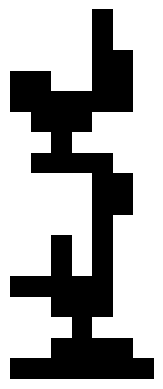

In [29]:
import matplotlib.pyplot as plt
import numpy as np

jets0 = parse17("examples/example17.txt")
space0_test,ymax0_test = dropRocks(jets0,10)

spacetest = np.zeros((ymax0_test+1,7))
for (x,y),v in space0_test.items():
    if v:
        spacetest[y][x] = 1

plt.imshow(spacetest,origin='lower',cmap="binary")
_ = plt.axis('off')

In [30]:
space0,ymax0 = dropRocks(jets0,2022)
print("Test 1:",ymax0)

Test 1: 3068


In [32]:
jets = parse17("AOC2022inputs/input17.txt")
space,ymax = dropRocks(jets,2022)
print("Part 1:",ymax)

Part 1: 3209
